In [45]:
# imported modules
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from enum import Enum, auto
from matplotlib.colors import ListedColormap, BoundaryNorm

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)

In [77]:
# imported data
MONSTER_DF = pd.read_csv('monster_import.csv').fillna(False)
MONSTER_DF['rank'] = pd.Categorical(MONSTER_DF['rank'] , categories=['minion', 'master', 'boss'], ordered=True)
MAP_TILE_DF = pd.read_csv('tile_import.csv')

display(MONSTER_DF.head())
display(MAP_TILE_DF.head())

,name,rank,expansion,quantity,height,width,power,boss,minion,movement,health,armor,abilities
0,Bane Spider,minion,base,6,2,2,2,False,True,5,3,1,Poison
1,Bane Spider Master,master,base,3,2,2,3,False,True,5,4,2,"Poison, Web"
2,Beastman,minion,base,6,1,1,1,False,True,4,3,2,+1 Damage
3,Beastman Master,master,base,3,1,1,3,True,True,4,4,3,"+2 Damage, Command"
4,Blood Ape,minion,AoD,4,2,1,6,False,True,4,8,3,Leap


,id,expansion,quantity,height,width,blanks,spawn
0,R6,base,4,4,6,NaN,"[(0,2),(0,3),(1,0),(1,5),(2,0),(2,5),(3,2),(3,3)]"
1,L4,base,4,4,4,"[(0,2),(0,3),(1,2),(1,3)]","[(0,0),(0,1),(2,3),(3,3)]"
2,S4,base,4,4,4,NaN,"[(0,1),(0,2),(1,0),(1,3),(2,0),(2,3),(3,1),(3,2)]"
3,S6,base,2,6,6,NaN,"[(0,2),(0,3),(2,0),(2,5),(3,0),(3,5),(5,2),(5,3)]"
4,T,base,4,4,4,"[(2,0),(2,3),(3,0),(3,3)]","[(0,0),(0,3),(1,0),(1,3),(3,1),(3,2)]"


In [86]:
main.monsters_obj._DATA

,name,expansion,quantity,height,width,power,boss,minion,movement,health,armor,abilities
0,Deep Elf,AoD,2,1,1,4,False,False,5,6,3,"Shadowcloak, Pierce 3"
1,Deep Elf Master,AoD,1,1,1,6,False,False,5,7,4,"Shadowcloak, Pierce 6, Frost"
2,Giant,base,1,2,2,7,False,False,3,10,5,"Reach, Stun"
3,Giant Master,base,1,2,2,8,False,False,3,11,6,"Reach, Stun, Sweep"
4,Kobold,WoD,12,1,1,1,False,True,3,3,0,Swarm
5,Kobold Master,WoD,6,1,1,1,False,True,3,4,1,"Swarm, Trickster"
6,Deep Elf Boss,AoD,1,1,1,6,True,False,5,7,4,"Shadowcloak, Pierce 6, Frost"


In [83]:
main.treasures_obj.encounters

{1: ['treasure_chest'],
 2: ['treasure_chest', 'money_marker', 'vitality_potion'],
 3: ['treasure_chest',
  'money_marker',
  'money_marker',
  'vitality_potion',
  'money_marker'],
 4: ['treasure_chest', 'money_marker', 'healing_potion']}

In [ ]:
# CONSTANTS

NOTHING = 0
JOIN = 0.5
FLOOR = 1
MONSTER = 10
MASTER = 20
OBSTACLE = 30
PIT = 31
TRAP = 32
ENTRANCE = 33
HEALING = 40
VITALITY = 41
TREASURE = 42
MONEY = 43

NOTHING_COLOUR = 'black'
JOIN_COLOUR = 'magenta'
FLOOR_COLOUR = 'lightgrey'
OBSTACLE_COLOUR = 'grey'
PIT_COLOUR = 'k'
TRAP_COLOUR = 'darkred'
HEALING_COLOUR = 'blue'
VITALITY_COLOUR = 'darkorange'
TREASURE_COLOUR = 'yellow'
MONSTER_COLOUR = 'lime'
MASTER_COLOUR = 'red'
MONEY_COLOUR = 'darkgreen'
ENTRANCE_COLOUR = 'white'

COLOURS = {
    NOTHING: NOTHING_COLOUR,
    JOIN: JOIN_COLOUR,
    FLOOR: FLOOR_COLOUR,
    OBSTACLE: OBSTACLE_COLOUR,
    PIT: PIT_COLOUR,
    TRAP: TRAP_COLOUR,
    HEALING: HEALING_COLOUR,
    VITALITY: VITALITY_COLOUR,
    TREASURE: TREASURE_COLOUR,
    MONSTER: MONSTER_COLOUR,
    MASTER: MASTER_COLOUR,
    MONEY: MONEY_COLOUR,
    ENTRANCE: ENTRANCE_COLOUR,
}

sns.color_palette(ListedColormap([x for x in COLOURS.values()]).colors)

In [5]:
class Treasures:
    ALL_AVAILABLE_TREASURE_MARKERS = {
        'healing_potion': 9, 
        'vitality_potion': 9, 
        'money_marker': 29,
        'treasure_chest': 8,  # note: treasure chests should automatically match to area level
        'invulnerability_potion': 9,
        'power_potion': 9,
        'invisibility_potion': 9,
        'relic_marker': 11,
    }

    def __init__(self, n_encounters=4, n_treasure_per_encounter=3, always_chest=True, fancy_chance=0.2, expansions=False):
        self.available_treasures = self.ALL_AVAILABLE_TREASURE_MARKERS.copy() if expansions else self.available_treasures.copy()[:4]
        self.encounters = self.generate_encounters(n_encounters, n_treasure_per_encounter, always_chest, fancy_chance)
        
    def generate_encounters(self, n_encounters, n_treasure_per_encounter, always_chest, fancy_chance):
        encounter_dict = dict()
        for i in range(n_encounters):
            encounter_dict[i+1] = ['treasure_chest'] if always_chest else list()
            self.available_treasures['treasure_chest'] -= 1 if always_chest else 0

        n_total = n_treasure_per_encounter * n_encounters
        n_total -= n_encounters if always_chest else 0
        
        for _ in range(n_total):
            all_treasures = [x for x in self.available_treasures.keys() if self.available_treasures[x] > 0]
            all_treasures = all_treasures[:3] * int(1/fancy_chance) + all_treasures[3:]
            treasure = np.random.choice(all_treasures)
            encounter_dict[np.random.choice(list(encounter_dict.keys()))] += [treasure]
            self.available_treasures[treasure] -= 1

        return encounter_dict


In [131]:
class Monsters:
    # constants
    MIN_ENEMY_PER_ENCOUNTER = 2
    
    def __init__(self, dataframe, n_monsters=3, n_encounters=4, boss=True, sorted_battles=True, use_all_minis=False):
        self._MINIONS = sorted(list({x.replace('Master', '').strip() for x in dataframe[dataframe.minion].name}))
        self._NOT_MINIONS = sorted(list({x.replace('Master', '').strip() for x in dataframe[~dataframe.minion].name}))
        self._BOSSES = sorted(list({x.replace('Master', '').strip() for x in dataframe[dataframe.boss].name}))
        self.quest_monsters = None
        self.quest_boss = None
        
        # choose monsters
        self.choose_monsters(n_monsters)
        self.choose_boss(boss)
        
        # summarise relevant data
        self._DATA = dataframe[dataframe.name.str.contains('|'.join(self.quest_monsters))]
        self._DATA.loc[:, 'boss'] = False
        if boss:
            boss_df = dataframe[dataframe.name.str.contains(self.quest_boss) & dataframe.boss].copy()
            boss_df['rank'] = 'boss'
            self._DATA = pd.concat([self._DATA, boss_df])
            self._DATA.iloc[-1, 0] = self._DATA.iloc[-1, 0].replace('Master', 'Boss')
        self._DATA = self._DATA.sort_values('rank', ascending=False).reset_index(drop=True)
        n_minions = self._DATA.value_counts('rank')['minion']
        self._DATA.index = [x + 20 - n_minions if x > n_minions else x + 10 for x in self._DATA.index]
        self._DATA = self._DATA
        
        # use summarised data to create list of all monster tokens
        self.minis = list()
        self.used_minis = list()
        self.choose_minis(use_all_minis, n_encounters)
            
        # calculate total power of all minis combined (not including boss, if applicable)
        self._total_power = self.calc_total_power(self.minis[:-1])
        
        # create a list of encounters
        self.encounters = self.generate_encounters(n_encounters, sorted_battles)
        
    def choose_monsters(self, n_monsters):
        n_minions = np.random.randint(1, n_monsters)
        minions = np.random.choice(self._MINIONS, n_minions, replace=False)
        not_minions = np.random.choice(self._NOT_MINIONS, n_monsters-n_minions, replace=False)
        self.quest_monsters = sorted(list(set(minions) | set(not_minions)))
      
    def choose_boss(self, boss):
        if boss:
            self.quest_boss = np.random.choice(self._BOSSES)
            
    def choose_minis(self, use_all_minis, n_encounters):
        for monster in self.quest_monsters:
            n_normal, n_master = self._DATA.loc[self._DATA.name.str.contains(monster) & ~self._DATA.name.str.contains('Boss'), 'quantity']
            for _ in range(n_normal):
                self.minis.append(monster)
            for _ in range(n_master):
                self.minis.append(monster + ' Master')
        if not use_all_minis:
            n_iterations = 3  # more iterations favours larger number of utilised minis
            n_enemies = np.random.randint(n_encounters * self.MIN_ENEMY_PER_ENCOUNTER+1, len(self.minis)+1, n_iterations).max()
            self.minis = sorted(np.random.choice(self.minis, n_enemies))
        if self.quest_boss:
            if self.quest_boss + ' Master' in self.quest_monsters:
                self.minis.remove(self.quest_boss + ' Master')
            self.minis.append(self.quest_boss + ' Boss')
            
    def summarise(self):
        print('\nQuest Monsters\n================')
        for monster in self.quest_monsters:
            print(monster)
        print()
        
        if self.quest_boss:
            print('\nQuest Boss\n================')
            print(self.quest_boss)
            print()
            
    def get_power(self, name_of_monster):
        if 'boss' in name_of_monster.lower():
            return 20  # arbitrary magic number for boss power for sorting
        return self._DATA.loc[self._DATA.name == name_of_monster, 'power'].iloc[0]
    
    def calc_total_power(self, list_of_monsters):
        total_power = 0
        for monster in list_of_monsters:
            total_power += self.get_power(monster)
        return total_power
            
    def generate_encounters(self, n_encounters, sorted_battles):
        # confirm min enemies per encounter is possible
        if len(self.minis[:-1]) < self.MIN_ENEMY_PER_ENCOUNTER*n_encounters:
            raise NotEnoughEnemiesToHaveSoManyEncountersError
        
        # create encounters
        enough_enemies_per_encounter = False
        while not enough_enemies_per_encounter:
            enough_enemies_per_encounter = True
            encounter_dict = dict()
            for i in range(n_encounters):
                encounter_dict[i+1] = list()

            for mini in self.minis[:-1]:
                encounter_dict[np.random.randint(1, n_encounters+1)] += [mini]
            encounter_dict[n_encounters] += [self.minis[-1]]  # add the boss to final encounter
        
            # confirm that all encounters have enough enemies, otherwise try again
            for encounter in encounter_dict.values():
                if len(encounter) < self.MIN_ENEMY_PER_ENCOUNTER:
                    enough_enemies_per_encounter = False

        # sort the non-boss items by difficulty
        if sorted_battles:
            difficulty = dict()
            for i in range(1, n_encounters):
                difficulty[i] = self.calc_total_power(encounter_dict[i])

            sorted_dict = encounter_dict.copy()
            for i, k in enumerate(sorted(difficulty, key=difficulty.get, reverse=False)):
                sorted_dict[i+1] = encounter_dict[k]
                
            encounter_dict = sorted_dict

        return encounter_dict
        

In [7]:
class Tiles:
    def __init__(self, obj):
        # empty default tileset - fills up as tiles are used
        self.tiles = dict()
        self.unused_tiles = dict()
        
        # generate all tiles
        if isinstance(obj, pd.DataFrame):
            self.create_map_tiles(obj)
        elif isinstance(obj, Monsters):
            self.create_monster_tiles(obj)
        else:
            raise OnlyWorksOnMonstersAndMaptilesError
        
    def create_map_tiles(self, dataframe):
        for _, row in dataframe.iterrows():
            for j in range(row['quantity']):
                name = row['id'] + '_' + str(j + 1)
                tile = pd.DataFrame(np.ones((row['height'], row['width'])))
                # blanks
                if pd.notna(row['blanks']):
                    for blank in eval(row['blanks']):
                        tile.iloc[blank] = None
                # spawn points
                if pd.notna(row['spawn']):
                    for x, y in eval(row['spawn']):
                        tile.iloc[x, y] = 0.5
                self.unused_tiles[name] = tile
                
    def create_monster_tiles(self, obj):
        # these should automatically have rows consistent with plotting colour ranges
        dataframe = obj._DATA.copy()
        for idx, row in dataframe.iterrows():
            for j in range(row['quantity']):
                name = row['name'] + ' ' + str(j + 1)
                tile = pd.DataFrame(np.ones((row['height'], row['width']))) * idx
                self.unused_tiles[name] = tile        
        
    def rotate_tile(self, name_of_tile):
        if name_of_tile[0].lower() == 's':
            return
        t = self.unused_tiles[name_of_tile]
        t = t.sort_index(ascending=False).T.reset_index(drop=True)
        self.unused_tiles[name_of_tile] = t.rename({x:i for i, x in enumerate(t.columns)}, axis=1)
        
    def show_tile(self, name_of_tile, unused=True):
        if unused:
            display(self.unused_tiles[name_of_tile])
        else:
            display(self.tiles[name_of_tile])
    
    def use_tile(self, name_of_tile):
        self.tiles[name_of_tile] = self.unused_tiles.pop(name_of_tile)


In [54]:
class DescentMap:
    # cls constants
    DEBUGGING = False
    CROP_MAP = False
    BOSS_POWER_LIST = ['double HP', 'double attack dice', 'resurrect unless miss on 3 red']
    AVAILABLE_TERRAIN = ['obstacle', 'pit', 'trap']
    
    def __init__(self, n_monsters=3, n_encounters=4, n_treasure_per_encounter=3, boss=True, sorted_battles=True, use_all_minis=False, 
                 always_chest=True, unrevealed_areas=True, MAX_H=50, MAX_W=30, min_area_size=20, max_area_size=80):
        # obj constants
        self.MAX_H = MAX_H
        self.MAX_W = MAX_W
        self.MAP_TEMPLATE = pd.DataFrame(np.full(shape=(MAX_H, MAX_W, ), fill_value=np.nan))
        self.N_ENCOUNTERS = n_encounters
        self.MIN_AREA_SIZE = min_area_size
        self.MAX_AREA_SIZE = max_area_size

        # create objects
        self.monsters_obj = Monsters(MONSTER_DF, n_monsters, n_encounters, boss, sorted_battles, use_all_minis)
        self.treasures_obj = Treasures(n_encounters, n_treasure_per_encounter, always_chest)
        self.map_tiles_obj = Tiles(MAP_TILE_DF)
        self.monster_tiles_obj = Tiles(self.monsters_obj)
        
        # initialise variables
        self.unrevealed_areas = unrevealed_areas
        self.current_area = 1
        self._current_area_size = 0
        self.choose_area_size()
        self.terrain_dict = dict()
        self.treasure_dict = dict()
        self.area_dict = {n+1:list() for n in range(n_encounters)}
        
        # layers
        self.grid_map = self.MAP_TEMPLATE.copy()  # null, 1, or 0.5/spawn 
        self.area_map = self.MAP_TEMPLATE.copy()  # 1, 2, 3, n+1 for Boss
        self.terrain_map = self.MAP_TEMPLATE.copy()  # inpass, hole, dungeon entrance, etc
        self.monster_map = self.MAP_TEMPLATE.copy()
        self.treasure_map = self.MAP_TEMPLATE.copy()
        
        # set up map
        self.create_dungeon_entrance()
    
    def place_tile(self, name_of_tile, x, y, obj):
        tile = obj.unused_tiles[name_of_tile]
        obj.use_tile(name_of_tile)
        w, h = tile.shape
        self.grid_map.iloc[y:y+w, x:x+h] = tile
    
    def add_map_tile_to_current_area(self, name_of_tile):
        self.area_dict[self.current_area].append(name_of_tile)

    def _fill_area_map(self):
        mask = self.grid_map.notnull() & self.area_map.isnull()
        self.area_map[mask] = self.current_area
    
    def place_map_tile(self, name_of_tile, x, y):
        obj = self.map_tiles_obj
        self.add_map_tile_to_current_area(name_of_tile)
        self.place_tile(name_of_tile, x, y, obj)
        self._fill_area_map()
            
    def place_monster_tile(self, name_of_tile, x, y):
        obj = self.monsters_obj
        self.place_tile(name_of_tile, x, y, obj)
    
    def place_terrain(self, name_of_item, x, y):
        TERRAIN_INDEX_START = 30  # TODO: look up from known indices for mapping / plotting
        if name_of_item not in self.terrain_dict.values():
            self.terrain_dict[TERRAIN_INDEX_START+len(self.terrain_dict)] = name_of_item
        self.terrain_map.iloc[y, x] = {v:k for k,v in self.terrain_dict.items()}[name_of_item]
    
    def place_treasure(self, name_of_item, x, y):
        TREASURE_INDEX_START = 40  # TODO: look up from known indices for mapping / plotting
        if name_of_item not in self.treasure_dict.values():
            self.treasure_dict[TREASURE_INDEX_START+len(self.terrain_dict)] = name_of_item
        self.treasure_map.iloc[y, x] = {v:k for k,v in self.treasure_dict.items()}[name_of_item]
    
    def create_dungeon_entrance(self):
        """hardcoded spawn location / configuration - consider revising"""
        OFFSET_FROM_BOTTOM = 1
        START_X, START_Y = self.MAX_W // 2, self.MAX_H - OFFSET_FROM_BOTTOM
        self.place_map_tile('Cap_1', START_X, START_Y)
        self.place_map_tile('H2_1', START_X, START_Y-2)
        self.grid_map.iloc[START_Y-1:START_Y+1, START_X:START_X+2] = 1
        self.place_terrain('dungeon_entrance', START_X, START_Y)
        self.place_terrain('dungeon_entrance', START_X+1, START_Y)
    
    @property
    def spawn_points(self):
        filtered = self.grid_map.applymap(lambda x: x == 0.5).stack()
        return [(x, y) for y,x in filtered[filtered].index.tolist()]
    
    @property
    def size(self):
        return self.grid_map.count().sum()

    @property
    def current_area_size(self):
        return (self.area_map == self.current_area).sum().sum()
    
    @property
    def tiles(self):
        return self.map_tiles_obj.tiles

    @property
    def unused_tiles(self):
        return self.map_tiles_obj.unused_tiles

    @property
    def combined_map(self, crop=True):
        combined_map = self.grid_map.copy()
        for layer in [self.terrain_map, self.monster_map, self.treasure_map]:
            combined_map = layer.combine_first(combined_map)
        
        if self.CROP_MAP:
            # crop map, removing all rows and columns that are entirely null
            combined_map = combined_map.loc[combined_map.notnull().any(axis=1), combined_map.notnull().any(axis=0)]
        
        # mask unrevealed areas
        if self.unrevealed_areas:
            mask = self.area_map > self.current_area
            combined_map[mask] = np.nan
        
        return combined_map

    @property
    def tiles_remaining(self):
        """not including caps"""
        return len([x for x in self.unused_tiles if x[:3] != 'Cap'])

    @property
    def caps_remaining(self):
        return len([x for x in self.unused_tiles if x[:3] == 'Cap'])

    @property
    def spawn_points_remaining(self):
        return len(self.spawn_points)
    
    @property
    def distinct_spawn_points(self):
        to_cap = self.spawn_points
        for i, coordinates in enumerate(to_cap):
            paired_coordiates = self.get_spawns_pair_coordinates(*coordinates)
            if paired_coordiates in to_cap:
                to_cap[i] = paired_coordiates

        # sorted so that lower spawn points are capped first (greater y value, lower on map)
        return sorted(list(set(to_cap)), key=lambda x: x[1], reverse=True)

    @property
    def new_tile_mask(self):
        new_tile_mask = self.grid_map.copy()
        for x, y in self.distinct_spawn_points:
            new_tile_mask = self.spawn_square_df(x, y).combine_first(new_tile_mask)
        return new_tile_mask

    # procedural map generation

    def choose_random_tile(self):
        if self.tiles_remaining == 0:
            if self.caps_remaining == 0:
                return None
            return self.get_cap()
        n_attempts_without_hallways = 3  # TODO: consider making a constant, or just leave as a magic number
        for _ in range(n_attempts_without_hallways):
            name_of_tile = np.random.choice([x for x in self.unused_tiles if x[:3] != 'Cap'])
            if name_of_tile[0] != 'H':
                break
        return name_of_tile
    
    def use_tile(self, name_of_tile):
        self.map_tiles_obj.use_tile(name_of_tile)

    def choose_random_spawn_point(self):
        return self.spawn_points[np.random.randint(0, len(self.spawn_points))]
    
    def get_spawn_direction(self, x, y):
        direction = None

        directions = dict(
            up =  self.grid_map.iloc[y-1, x-1:x+2],
            down = self.grid_map.iloc[y+1, x-1:x+2],
            left = self.grid_map.iloc[y-1:y+2, x-1],
            right = self.grid_map.iloc[y-1:y+2, x+1],
        )
        if directions['up'].isnull().all() and (directions['down'].iloc[1] != 0.5).all():
            direction = 'up'
        if directions['down'].isnull().all() and (directions['up'].iloc[1] != 0.5).all():
            direction = 'ERROR' if direction else 'down'
        if directions['left'].isnull().all() and (directions['right'].iloc[1] != 0.5).all():
            direction = 'ERROR' if direction else 'left'
        if directions['right'].isnull().all() and (directions['left'].iloc[1] != 0.5).all():
            direction = 'ERROR' if direction else 'right'

        return direction

    def get_spawns_pair_coordinates(self, x, y):
        coordinate = None

        directions = dict(
            up =  self.grid_map.iloc[y-1, x-1:x+2],
            down = self.grid_map.iloc[y+1, x-1:x+2],
            left = self.grid_map.iloc[y-1:y+2, x-1],
            right = self.grid_map.iloc[y-1:y+2, x+1],
        )
        if (directions['up'].iloc[1] == 0.5).any():
            coordinate = (x, y-1)
        if (directions['down'].iloc[1] == 0.5).any():
            coordinate = 'ERROR' if coordinate else (x, y+1)
        if (directions['left'].iloc[1] == 0.5).any():
            coordinate = 'ERROR' if coordinate else (x-1, y)
        if (directions['right'].iloc[1] == 0.5).any():
            coordinate = 'ERROR' if coordinate else (x+1, y)

        return coordinate
    
    def get_spawn_square(self, x1, y1, direction):
        if self.DEBUGGING:
            print('get_spawn_square')
            print(f'square start: {x1}, {y1}')
        x3, y3 = x1, y1
        x4, y4 = x2, y2 = self.get_spawns_pair_coordinates(x1, y1)
        if self.DEBUGGING:
            print(f'pair coordicates: {x2}, {y2}')
        if direction == 'up':
            y3 -= 1
            y4 -= 1
        elif direction == 'down':
            y3 += 1
            y4 += 1
        elif direction == 'left':
            x3 -= 1
            x4 -= 1
        elif direction == 'right':
            x3 += 1
            x4 += 1
        return [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    
    def spawn_square_df(self, x, y, fill_value=1):
        ss = self.get_spawn_square(x, y, self.get_spawn_direction(x, y))
        return pd.DataFrame(np.full(shape=(2, 2, ), fill_value=fill_value), 
                            columns=sorted(list({x[0] for x in ss})), 
                            index=sorted(list({x[1] for x in ss})))

    def confirm_two_adjacent_values(self, series, value=0.5):
        if (series == value).sum() != 2:
            return False
        indices = series[series == value].index
        return indices[1] == indices[0] + 1

    def confirm_spawn_possible(self, name_of_tile, x, y):
        direction = self.get_spawn_direction(x, y)
        if direction:
            if direction == 'up':
                series = self.map_tiles_obj.unused_tiles[name_of_tile].iloc[-1, :]
            elif direction == 'down':
                series = self.map_tiles_obj.unused_tiles[name_of_tile].iloc[0, :]
            elif direction == 'left':
                series = self.map_tiles_obj.unused_tiles[name_of_tile].iloc[:, -1]
            elif direction == 'right':
                series = self.map_tiles_obj.unused_tiles[name_of_tile].iloc[:, 0]
        else:
            return False
        return self.confirm_two_adjacent_values(series)

    def rotate_tile(self, name_of_tile):
        self.map_tiles_obj.rotate_tile(name_of_tile)

    def tile_spawn_offset(self, name_of_tile, x, y):
        x1, y1 = x, y
        direction = self.get_spawn_direction(x, y)
        spawn_square = self.get_spawn_square(x, y, direction)
        x_min_spawn = min(x[0] for x in spawn_square)
        y_max_spawn = min(x[1] for x in spawn_square) # reversed because of inverted y-axis
        
        if self.DEBUGGING:
            print('tile_spawn_offset')
            print(f"'{name_of_tile}', {x}, {y}")
            print('spawn possible?', self.confirm_spawn_possible(name_of_tile, x, y))
            print(direction)
        
        for _ in range(4):
            tile = self.map_tiles_obj.unused_tiles[name_of_tile]
            h, w = tile.shape
            if self.DEBUGGING:
                display(tile)
            if self.confirm_spawn_possible(name_of_tile, x, y):
                if direction == 'left':
                    x_offset = -w
                    tile_spawn_pt_location = -tile.iloc[:, -1].eq(0.5).idxmax()
                    offset_correction = y_max_spawn - y
                    y_offset = offset_correction + tile_spawn_pt_location
                    if self.DEBUGGING:
                        print('tile point', tile_spawn_pt_location)
                        print('offset correction', offset_correction, y)
                        print('total offset', y_offset)
                    x1, y1 = x + x_offset, y + y_offset
                elif direction == 'right':
                    x_offset = 1
                    tile_spawn_pt_location = -tile.iloc[:, 0].eq(0.5).idxmax()
                    offset_correction = y_max_spawn - y
                    y_offset = offset_correction + tile_spawn_pt_location
                    x1, y1 = x + x_offset, y + y_offset
                    if self.DEBUGGING:
                        print('tile point', tile_spawn_pt_location)
                        print('offset correction', offset_correction, y)
                        print('total offset', y_offset)
                elif direction == 'up':
                    y_offset = -h
                    tile_spawn_pt_location = -tile.iloc[-1, :].eq(0.5).idxmax()
                    offset_correction = x_min_spawn - x
                    x_offset = tile_spawn_pt_location + offset_correction
                    if self.DEBUGGING:
                        print('tile point', tile_spawn_pt_location)
                        print('offset correction', offset_correction, y)
                        print('total offset', y_offset)
                    x1, y1 = x + x_offset, y + y_offset
                elif direction == 'down':
                    y_offset = 1
                    tile_spawn_pt_location = -tile.iloc[0, :].eq(0.5).idxmax()
                    offset_correction = x_min_spawn - x
                    x_offset = tile_spawn_pt_location + offset_correction
                    if self.DEBUGGING:
                        print('tile point', tile_spawn_pt_location)
                        print('offset correction', offset_correction, y)
                        print('total offset', y_offset)
                    x1, y1 = x + x_offset, y + y_offset
                if self.DEBUGGING:
                    print(f'location to spawn: {x1}, {y1}')
                    print()
                return x1, y1
            else:
                if self.DEBUGGING:
                    print('ROTATE!')
                    print()
                self.rotate_tile(name_of_tile)

        return None  # if there are no eligible spawn points, return None

    def confirm_spawn_fits(self, name_of_tile, x_o, y_o, direction, x_s, y_s):
        """_o denotes origin coordinate, _s denotes spawn point coordinate"""
        tile = self.map_tiles_obj.unused_tiles[name_of_tile]
        h, w = tile.shape

        # check if tile fits in grid with 1 cell buffer
        if x_o < 1 or x_o+w > self.MAX_W-1 or y_o < 1 or y_o+h > self.MAX_H-1:
            return False
        
        # check if tile fits in all null areas with 1 cell buffer (will include room to at least cap all spawn points)
        if name_of_tile[:3] == 'Cap':
            # caps don't need buffers
            left, right, up, down = 0, 0, 0, 0
        else:
            left = 0 if direction == 'right' else 1
            right = 0 if direction == 'left' else 1
            up = 0 if direction == 'down' else 1
            down = 0 if direction == 'up' else 1
        if self.DEBUGGING:
            print('confirm_spawn_fits')
            print(f'h: {h}, w: {w}, direction: {direction}')
            print(f'left: {left}, right: {right}, up: {up}, down: {down}')
            print(f'.iloc[{y_o-up}:{y_o+h+down}, {x_o-left}:{x_o+w+right}].isnull().all().all()')
            display(self.grid_map.iloc[y_o-up:y_o+h+down, x_o-left:x_o+w+right])
            print('does it fits? ', self.grid_map.iloc[y_o-up:y_o+h+down, x_o-left:x_o+w+right].isnull().all().all())
            print()

        spawn_mask = self.new_tile_mask
        spawn_mask[self.spawn_square_df(x_s, y_s, True)] = np.nan
        return spawn_mask.iloc[y_o-up:y_o+h+down, x_o-left:x_o+w+right].isnull().all().all()

    def clean_used_spawn_square(self, list_spawn_square_output):
        for x, y in list_spawn_square_output:
            self.grid_map.iloc[y, x] = 9.9 if self.DEBUGGING else 1

    def randomly_rotate_tile(self, name_of_tile):
        n_rotations = np.random.choice(range(4))
        for _ in range(n_rotations):
            self.rotate_tile(name_of_tile)

    def get_cap(self):
        return [x for x in self.unused_tiles if x[:3] == 'Cap'][0]

    def spawn_tile(self, name_of_tile=None, spawn_point=None, show=False):
        # check that there are available spawn points
        if len(self.spawn_points) == 0:
            print('Nowhere to spawn tiles...\n')
            if show:
                display(self.grid_map.fillna(''))
            return

        # properties of the spawn point and it's tile
        x, y = spawn_point if spawn_point else self.choose_random_spawn_point()
        direction = self.get_spawn_direction(x, y)
        spawn_square_output = self.get_spawn_square(x, y, direction)

        # properties of the new tile
        name_of_tile = name_of_tile if name_of_tile else self.choose_random_tile()

        # randomly rotate tile
        self.randomly_rotate_tile(name_of_tile)

        # if the first tile doesn't fit, attempt a few more before giving up and capping
        how_many_attempts = 10  # TODO: maybe make this a parameter, or just leave as a magic number
        for _ in range(how_many_attempts):
            # attempt to place the tile, rotate if required
            for _ in range(4):
                tile_offset = self.tile_spawn_offset(name_of_tile, x, y)
                if tile_offset:
                    x1, y1 = tile_offset
                    if self.confirm_spawn_fits(name_of_tile, x1, y1, direction, x, y):
                        self.place_map_tile(name_of_tile, x1, y1)
                        self.clean_used_spawn_square(spawn_square_output)

                        if show:
                            display(self.grid_map.fillna(''))
                        return
                else:  
                    self.rotate_tile(name_of_tile)  # rotate tile
                    if self.DEBUGGING:
                        print('ERROR: tile cannot be placed. rotating tile.')
            # before capping, try a few more tiles
            name_of_tile = self.choose_random_tile()

        # if no eligible rotations found, cap the end
        if self.caps_remaining <= 0:
            print('BIG ERROR: map cannot be completed. no caps remain.') # TODO: remove this when working, consider capping end
            return

        name_of_tile = self.get_cap()
        for _ in range(2):
            tile_offset = self.tile_spawn_offset(name_of_tile, x, y)
            if tile_offset:
                self.place_map_tile(name_of_tile, tile_offset[0], tile_offset[1])
                self.clean_used_spawn_square(spawn_square_output)

                if show:
                    display(self.grid_map.fillna(''))
                return
            else:  
                self.rotate_tile(name_of_tile)  # rotate tile
                print('BIG ERROR: map cannot be completed... but I am not really sure why...') # TODO: remove this when working, consider capping end

    def cap_if_close_to_edge(self, dist=5):
        for x, y in self.distinct_spawn_points:
            if (x < dist) or (x > self.MAX_W - dist) or (y < dist) or (y > self.MAX_H - dist):
                self.spawn_tile(self.get_cap(), (x, y))

    def cap_lowest_spawn_points(self, n_to_leave=3):
        for x, y in self.distinct_spawn_points[:-n_to_leave]:
            self.spawn_tile(self.get_cap(), (x, y))

    def cap_all_except_n(self, n=1):
        xy_to_cap = random.sample(self.distinct_spawn_points, len(self.distinct_spawn_points) - n)
        for x, y in xy_to_cap:
            self.spawn_tile(self.get_cap(), (x, y))

    def choose_area_size(self):
        self._current_area_size = np.random.randint(self.MIN_AREA_SIZE, self.MAX_AREA_SIZE)
        
    def increment_area_number(self):
        self.current_area += 1
        
    def set_revealed_area(self, n):
        """just in case of accidental reveal, panic undo button"""
        if isinstance(n, int):
            self.current_area = n

    @property
    def _map_unfinishable(self):
        return self.caps_remaining < len(self.distinct_spawn_points)

    def _create_map_loop(self, show=False):
        for _ in range(self.N_ENCOUNTERS):
            while self.current_area_size < self._current_area_size:
                if (self.tiles_remaining == 0 
                    or self.spawn_points_remaining == 0
                    or self._map_unfinishable):
                    if self.DEBUGGING:
                        print("Whelp... That didn't work.")
                    if show:
                        display(self.grid_map.fillna(''))
                    return
                self.spawn_tile()

            if self._map_unfinishable:
                if self.DEBUGGING:
                    print("Whelp... That didn't work.")
                return

            self.cap_if_close_to_edge()
            self.cap_lowest_spawn_points()

            # choose connection to next area
            n = 1 if self.current_area < self.N_ENCOUNTERS else 0
            self.cap_all_except_n(n)
            self.increment_area_number()
            self.choose_area_size()

            if show:
                display(self.area_map.fillna(''))

    def create_map(self, n_attempts=10):
        for i in range(n_attempts):
            print(f'\nMAP CREATION ATTEMPT # {i+1}')
            self._create_map_loop()
            if self.current_area == self.N_ENCOUNTERS:
                if self.current_area_size >= self.MIN_AREA_SIZE:
                    return
            self.__init__()

    def create_terrain(self):
        """
        randomly choose obstacles, place obstacles randomly
        restrict obstacles from being placed on null cells from corresponding location in grid_map
        """
        ...

    def create_monsters(self):
        """
        randonly place monsters from self.monsters_obj.encounters into corrsponding areas
        """
        ...

    def create_treasures(self):
        """
        randonly place treasures from self.treasures_obj.encounters into corrsponding areas
        """
        ...
      
    # plotting function
    
    def show(self):
        SCALE = 0.5
        x, y = self.combined_map.shape
        
        cmap = ListedColormap([x for x in COLOURS.values()])
        norm = BoundaryNorm(
            list(COLOURS.keys()) + [max(list(COLOURS.keys()))+1], 
            cmap.N, 
            clip=True
        )
        
        plt.figure(figsize=(SCALE*y, SCALE*x))
        plt.pcolor(
            self.combined_map,
            cmap=cmap,
            norm=norm,
            edgecolors='k',
            linewidth=3,
        )
        
        # ticks and labels
        ax = plt.gca()
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.xaxis.tick_top()        
        plt.xticks([i+0.5 for i in range(y)], [i+1 for i in range(y)])
        plt.yticks([i+0.5 for i in range(x)], [i+1 for i in range(x)])
        
        # label monsters
        for i in range(x):
            for j in range(y):
                if self.grid[i, j] == MONSTER or self.grid[i, j] == MASTER:
                    if monster:= self.monsters[i, j]:
                        plt.text(j+0.5, i+0.5, monster, ha='center', va='center', color='black', size=label_size)
        
        plt.show()
    
    # OPTIONAL METHODS: tweaking the scenario
    
    def regenerate_map(self):
        pass
    
    def choose_new_monsters(self):
        pass
    
    def regenerate_encounters(self):
        pass
    
    def regenerate_obstacles(self):
        pass
    
    def add_more_obstacles(self):
        pass
    
    def regenerate_treasure(self):
        pass
    
    def add_more_treasure(self):
        pass

    def remove_some_treasure(self):
        pass


In [55]:
main = DescentMap()
main.create_map()


MAP CREATION ATTEMPT # 1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [78]:
m = Monsters(MONSTER_DF)

In [79]:
m._DATA

,name,rank,expansion,quantity,height,width,power,boss,minion,movement,health,armor,abilities
0,Lava Beetle,minion,ToI,4,1,1,1,False,True,3,4,2,Blast 1
1,Lava Beetle Master,master,ToI,2,1,1,1,False,True,3,5,3,"Blast 1, Burn"
2,Ogre,minion,base,2,2,2,5,False,False,3,6,4,Knockback
3,Ogre Master,master,base,1,2,2,6,False,False,3,7,5,"Knockback, Undying"
4,Skeleton,minion,base,6,1,1,1,False,True,5,3,0,"Pierce 1, +1 Range"
5,Skeleton Master,master,base,3,1,1,3,False,True,5,4,1,"Pierce 2, +2 Range, Undying"
6,Sorcerer Boss,master,base,2,1,1,5,True,True,4,5,3,"Sorcery 4, Undying"


In [71]:
MONSTER_DF

,name,expansion,quantity,height,width,power,boss,minion,movement,health,armor,abilities
0,Bane Spider,base,6,2,2,2,False,True,5,3,1,Poison
1,Bane Spider Master,base,3,2,2,3,False,True,5,4,2,"Poison, Web"
2,Beastman,base,6,1,1,1,False,True,4,3,2,+1 Damage
3,Beastman Master,base,3,1,1,3,True,True,4,4,3,"+2 Damage, Command"
4,Blood Ape,AoD,4,2,1,6,False,True,4,8,3,Leap
5,Blood Ape Master,AoD,2,2,1,7,False,True,4,9,5,"Leap, Berserk"
6,Chaos Beast,AoD,2,2,2,7,False,False,3,10,5,"Morph, Sorcery 1"
7,Chaos Beast Master,AoD,1,2,2,10,True,False,3,11,6,"Morph, Sorcery 2, Black Curse"
8,Dark Priest,AoD,4,1,1,3,False,True,4,4,2,Dark Prayer
9,Dark Priest Master,AoD,2,1,1,5,False,True,4,5,3,"Dark Prayer, Black Curse"


# V2 - bad, redo with better methodology

### Reference Colours

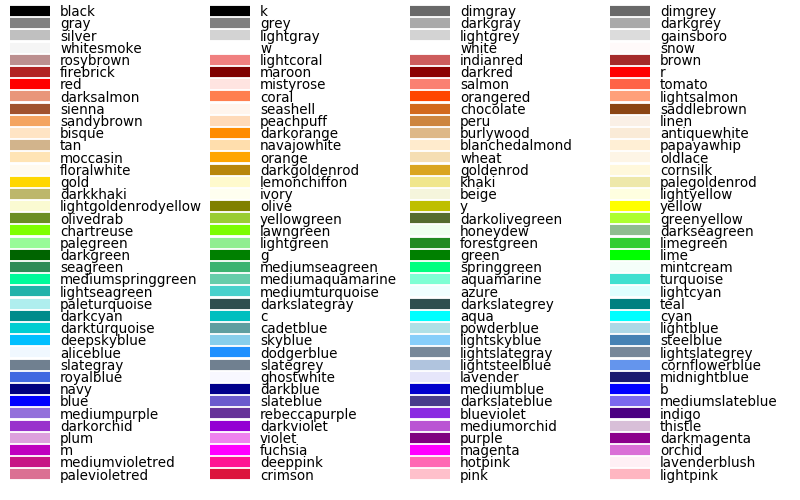

In [ ]:
# CONSTANTS

NOTHING = 0
JOIN = 0.5
FLOOR = 1
OBSTACLE = 2
STAMINA = 3
MANA = 4
BRONZE = 5
SILVER = 6
GOLD = 7
MONSTER = 8
MASTER = 9
ERROR = 10

NOTHING_COLOUR = 'black'
JOIN_COLOUR = 'magenta'
FLOOR_COLOUR = 'lightgrey'
OBSTACLE_COLOUR = 'grey'
STAMINA_COLOUR = 'cyan'
MANA_COLOUR = 'blue'
BRONZE_COLOUR = 'orange'
SILVER_COLOUR = 'white'
GOLD_COLOUR = 'yellow'
MONSTER_COLOUR = 'lime'
MASTER_COLOUR = 'red'
ERROR_COLOUR = 'k'

COLOURS = {
    NOTHING: NOTHING_COLOUR,
    JOIN: JOIN_COLOUR,
    FLOOR: FLOOR_COLOUR,
    OBSTACLE: OBSTACLE_COLOUR,
    STAMINA: STAMINA_COLOUR,
    MANA: MANA_COLOUR,
    BRONZE: BRONZE_COLOUR,
    SILVER: SILVER_COLOUR,
    GOLD: GOLD_COLOUR,
    MONSTER: MONSTER_COLOUR,
    MASTER: MASTER_COLOUR,
    ERROR: ERROR_COLOUR,
}

sns.color_palette(ListedColormap([x for x in COLOURS.values()]).colors)

[(0.0, 0.0, 0.0),
 (1.0, 0.0, 1.0),
 (0.8274509803921568, 0.8274509803921568, 0.8274509803921568),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 (0.0, 1.0, 1.0),
 (0.0, 0.0, 1.0),
 (1.0, 0.6470588235294118, 0.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 0.0),
 (0.0, 1.0, 0.0),
 (1.0, 0.0, 0.0),
 (0.0, 0.0, 0.0)]

In [ ]:
# test arrays

x = np.array([
    [0,JOIN,JOIN,0],
    [0.5,1,1,0.5],
    [0.5,1,1,0.5],
    [0,0.5,0.5,0]
])

y = np.array([
    [1,1,1,1,1,1,1,0,0],
    [1,1,4,1,1,5,1,0,0],
    [1,1,1,1,1,1,1,0,0],
    [1,1,8,8,1,1,1,0,0],
    [1,1,1,1,9,1,1,1,1],
    [1,1,1,1,1,1,1,2,1],
    [1,1,1,1,1,1,1,2,1],
    [0,0,1,1,1,1,1,2,1],
])

z = np.array([
    [0,1,2,3],
    [8,1,1,4],
    [7,1,1,5],
    [0,7,6,0]
])

w = np.array([
    [1,0.5],
    [1,2],
    [1,3],
    [1,4],
    [1,5],
    [1,6],
    [1,7],
    [1,8],
    [1,9],
    [1,10],
])

In [ ]:
monsters = np.full(x.shape, None)
monsters


array([[None, None, None, None],
       [None, None, None, None],
       [None, None, None, None],
       [None, None, None, None]], dtype=object)

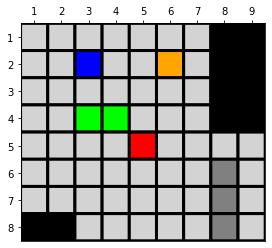

In [ ]:
class Tile:
    label_size = 20
    
    def __init__(self, grid: np.array):
        self.grid = grid
        self.monsters = np.full(grid.shape, None)
    
    def show(self):
        SCALE = 0.5
        x, y = self.grid.shape
        
        cmap = ListedColormap([x for x in COLOURS.values()])
        norm = BoundaryNorm(
            list(COLOURS.keys()) + [max(list(COLOURS.keys()))+1], 
            cmap.N, 
            clip=True
        )
        
        plt.figure(figsize=(SCALE*y, SCALE*x))
        plt.pcolor(
            self.grid,
            cmap=cmap,
            norm=norm,
            edgecolors='k',
            linewidth=3,
        )
        
        # ticks and labels
        ax = plt.gca()
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.xaxis.tick_top()        
        plt.xticks([i+0.5 for i in range(y)], [i+1 for i in range(y)])
        plt.yticks([i+0.5 for i in range(x)], [i+1 for i in range(x)])
        
        # label monsters
        for i in range(x):
            for j in range(y):
                if self.grid[i, j] == MONSTER or self.grid[i, j] == MASTER:
                    if monster:= self.monsters[i, j]:
                        plt.text(j+0.5, i+0.5, monster, ha='center', va='center', color='black', size=label_size)
        
        plt.show()

        
class Board(Tile):
    def __init__(self, grid):
        super().__init__(grid)
        self.__list_of_tiles = None
        self.add_tile(grid)
    
    def add_tile(self, othertile):
        if self.__list_of_tiles:
            if othertile in self.__list_of_tiles:
                raise AlreadyUsedThatTileError
            else:
                self.__list_of_tiles.append(othertile)
        else:
            self.__list_of_tiles = [othertile]  
        
    def show_tiles(self):
        # TODO: update this to display better for clarity
        return self.__list_of_tiles

    
@dataclass
class Game(Board):
    grid: Board = None
    n_areas: int = 3
    boss_area: bool = True
    unrevealed_areas: bool = True
    secret_boss: bool = False
    n_monster_types: int = np.random.choice(range(1, 5))
        
    def __post_init__(self):
        super().__init__(self.grid)
#         self.show()

    def join(self, othertile):
        pass
    
    def choose_tiles(self):
        # check list_of_tiles
        # add rand # of tiles to temp list if not used yet
        pass
    
    def choose_monsters(self):
        pass
    
    def place_monsters(self):
        pass
    
    def generate_extras(self):
        """generate list of monsters, treasures, etc"""
        pass
    
    def generate_area(self):
        """generate area, populate with extras"""
        tiles = self.choose_tiles()


# Tile(y).show()
# Board(y).show()
Game(y).show()

In [ ]:
Board(x).grid

array([[0. , 0.5, 0.5, 0. ],
       [0.5, 1. , 1. , 0.5],
       [0.5, 1. , 1. , 0.5],
       [0. , 0.5, 0.5, 0. ]])